# Generating synthetic test data from largest Fourier components

In [1]:
%matplotlib inline

from __future__ import division

import os
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from cartopy import util
import cartopy.crs as ccrs

import pyshtools # library for spherical harmonic transforms
from scipy.interpolate import interpn
import scipy.fftpack

In [2]:
plt.rcParams['figure.figsize'] = [10, 5] # larger inline plots
plt.rcParams['figure.dpi'] = 150         # keep fonts readable

## Getting SHTools working

In [264]:
# load 3D precip data @ daily frequency from CESM model
data_dir = '/local2/home/MDTF/inputdata/model/QBOi.EXP1.AMIP.001/day/'
file_path = os.path.join(data_dir, 'QBOi.EXP1.AMIP.001.PRECT.day.nc')
dataset = nc.Dataset(file_path)
print dataset.variables.keys()

[u'time', u'date', u'lat', u'lon', u'time_bnds', u'PRECT']


In [265]:
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]
print lats.shape, lons.shape
print dataset.variables['PRECT'].shape
data = dataset.variables['PRECT'][0,:,:]

(192,) (288,)
(2555, 192, 288)


In [266]:
# do fourier transform routines we're using play nice with 
# masked/missing data? 
# Quick & dirty solution: fill in with something plausible
print type(data)
print np.mean(data)
data2 = data.filled(np.mean(data))
print type(data2)

<class 'numpy.ma.core.MaskedArray'>
2.3094707e-08
<type 'numpy.ndarray'>


In [267]:
def quick_plot(lat, lon, data, title=''):
    data2, lon2 = util.add_cyclic_point(data, coord=lon) # avoid seam
    ax = plt.axes(projection=ccrs.PlateCarree())
    cf = plt.contourf(lon2, lat, data2, 60, transform=ccrs.PlateCarree())
    plt.colorbar(cf, extend ='both')
    ax.coastlines()
    if title != '':
        ax.set_title(title)
    plt.show()

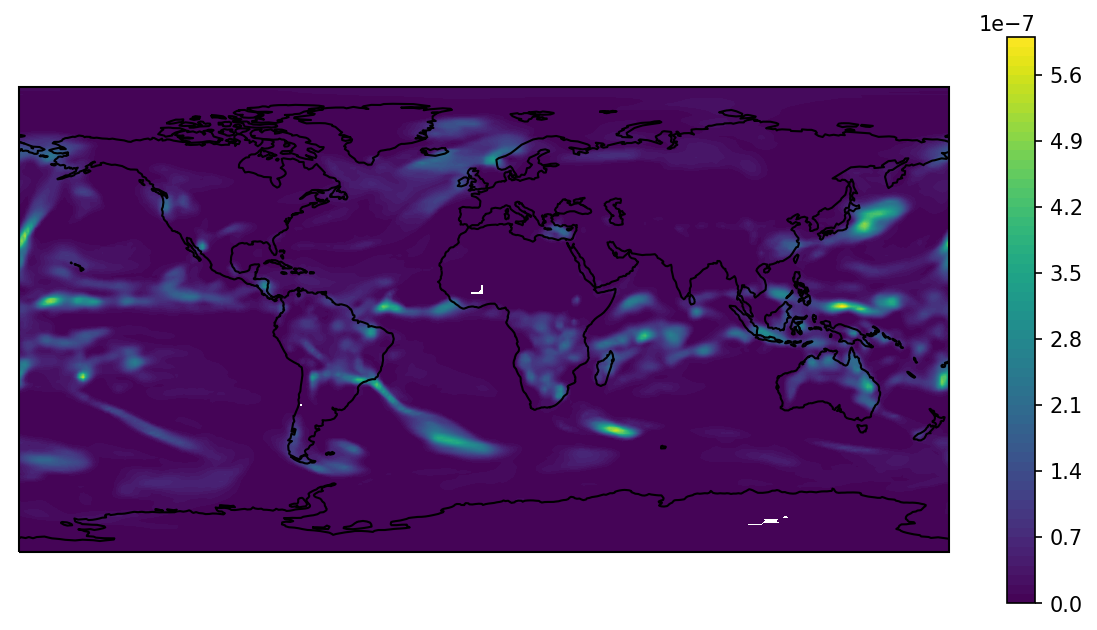

In [268]:
quick_plot(lats, lons, data2)

From what I can tell, the small white patches (eg in antarctica) aren't masked data, but locations with precip set to exactly 0.0. Not sure why the color bar isn't reflecting this.

In [11]:
# resample data to the grid required for the SH transform
n = max(lats.size, lons.size//2)
print n
new_lats = np.linspace(90, -90, n, endpoint=False)
new_lons = np.linspace(0, 360, 2*n, endpoint=False)
new_pts = np.array(np.meshgrid(new_lats, new_lons))
new_pts = np.transpose(new_pts, (2,1,0))
print new_pts.shape
new_data = interpn((lats, lons), data2, new_pts, 
                   method='linear', bounds_error=False, fill_value=None)
print new_data.shape

192
(192, 384, 2)
(192, 384)


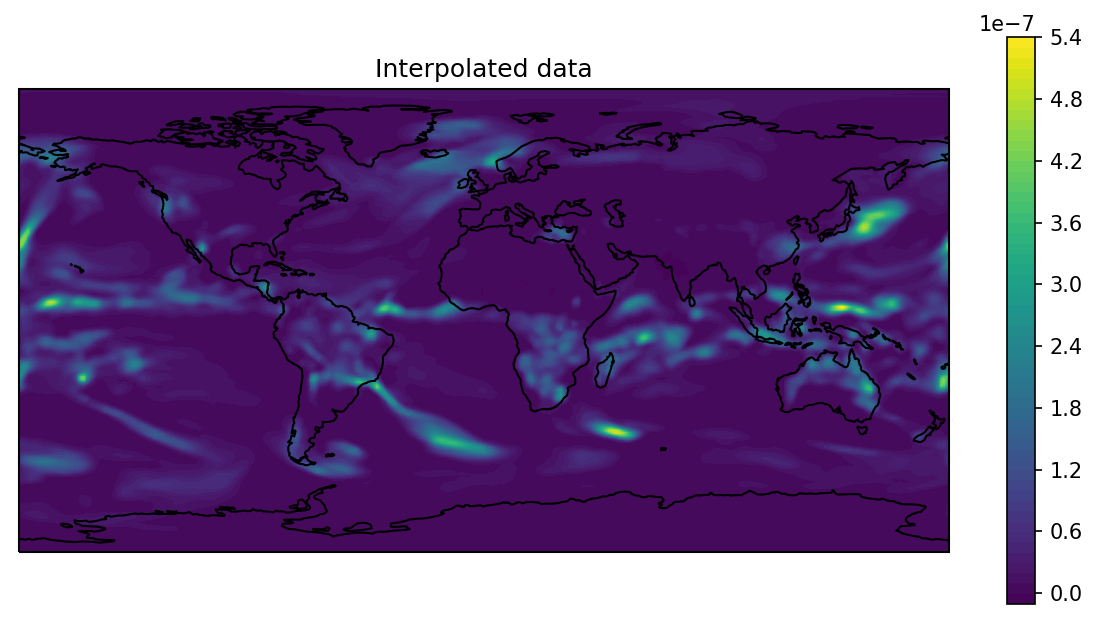

In [20]:
# verify we did that correctly
quick_plot(new_lats, new_lons, new_data,
          title = 'Interpolated data')

In [14]:
# perform the SH transform and get amplitudes of each coeff
# convention is that components of axis 0 are (cosine, sine) coefficients
# https://shtools.github.io/SHTOOLS/pyshexpanddh.html
coeffs = pyshtools.shtools.SHExpandDH(new_data, sampling=2)
print coeffs.shape
amplitudes = np.hypot.reduce(coeffs, 0)
print amplitudes.shape

(2, 96, 96)
(96, 96)


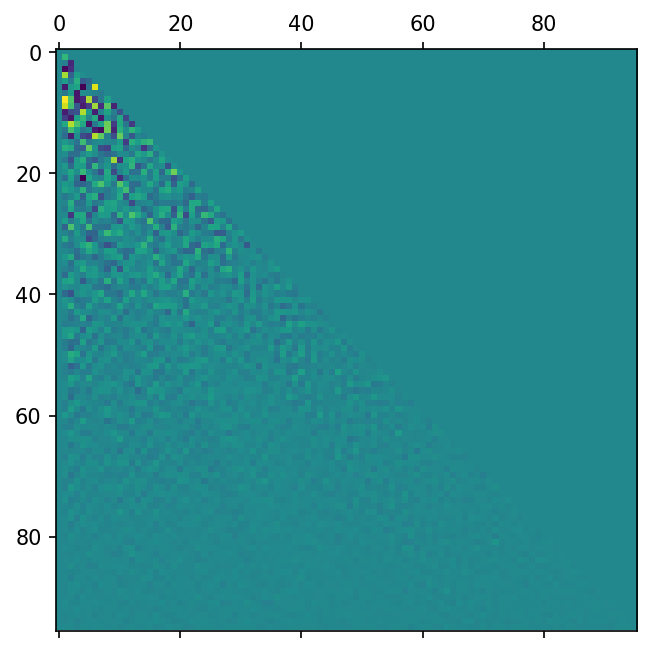

In [15]:
# convention of shtools is that coeffs[i,j] for j>i are 0
# instead of packing the array
plt.matshow(coeffs[1,:,:])
plt.show()

In [16]:
# threshold all but the n largest-amplitude coeffs to zero
n_to_keep = 250
# find n_to_keep'th largest element of an array:
thresh = np.partition(amplitudes.flatten(), -n_to_keep)[-n_to_keep]
print thresh
cut_cos = np.where(amplitudes > thresh, coeffs[0,:,:], 0.0)
cut_sin = np.where(amplitudes > thresh, coeffs[1,:,:], 0.0)
cut_coeffs = np.array([cut_cos, cut_sin])
print cut_coeffs.shape

1.4606825768198633e-09
(2, 96, 96)


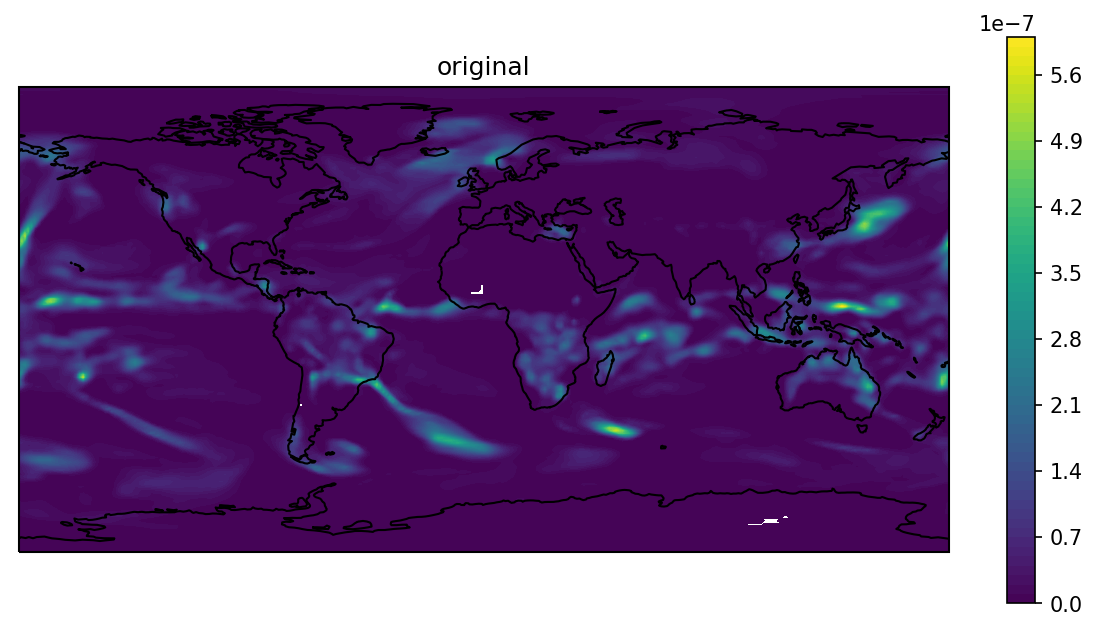

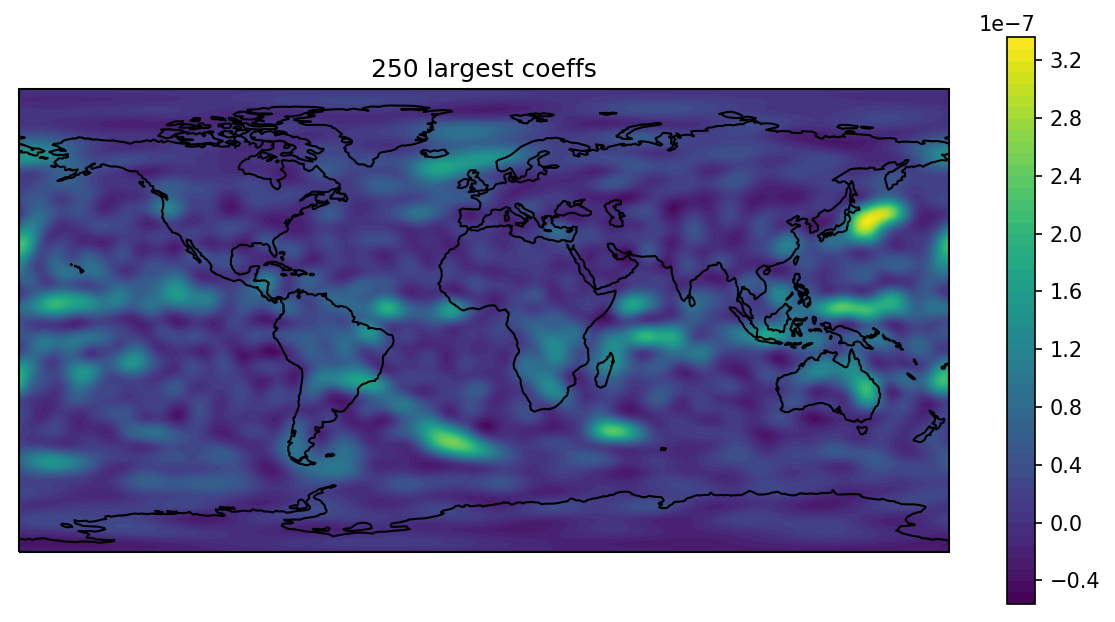

In [21]:
# reconstruct thresholded data with inverse transform
# https://shtools.github.io/SHTOOLS/pymakegriddh.html
cut_data = pyshtools.shtools.MakeGridDH(cut_coeffs, sampling=2)
quick_plot(lats, lons, data2, title='original')
quick_plot(new_lats, new_lons, cut_data, title='250 largest coeffs')

We chose precip as the most difficult case. Still, one can see that we reproduce the location of maxima pretty well, even if the fine detail is compeletely lost.

## OK, now let's add time-domain

Quick-and-dirty: Do spherical harmonic transform at each time slice, then do 1D time-domain FFT of the time series of each coefficient. Package the (cosine, sine) coefficients into one complex number (purely formally) so that we only need to do one FFT.

Currently *not* doing windowing or anything that would give a higher-quality transform of non-periodic data.

In [23]:
# subroutine to get spherical harmonics at each timestep
old_pts = (lats, lons)
vec_complex = np.vectorize(complex)
def sh_transform(data, old_pts, new_pts, vec_complex):
    old_data = np.nan_to_num(data)
    new_data = interpn(old_pts, old_data, new_pts, 
                       method='linear', bounds_error=False, fill_value=0.0)
    coeffs = pyshtools.shtools.SHExpandDH(new_data, sampling=2)
    return vec_complex(coeffs[0,:,:], coeffs[1,:,:])

In [24]:
# loop over timesteps, and do time-domain FFT at end
T = 100
n2 = n//2
temp = np.array(dataset.variables['PRECT'])
foo = np.zeros((T, n2, n2), dtype='complex128')
for t in range(T):
    foo[t,:,:] = sh_transform(temp[t,:,:], old_pts, new_pts, vec_complex)
del temp
for i in range(n2):
    for j in range(i+1):
        foo[:,i,j] = scipy.fftpack.fft(foo[:,i,j])

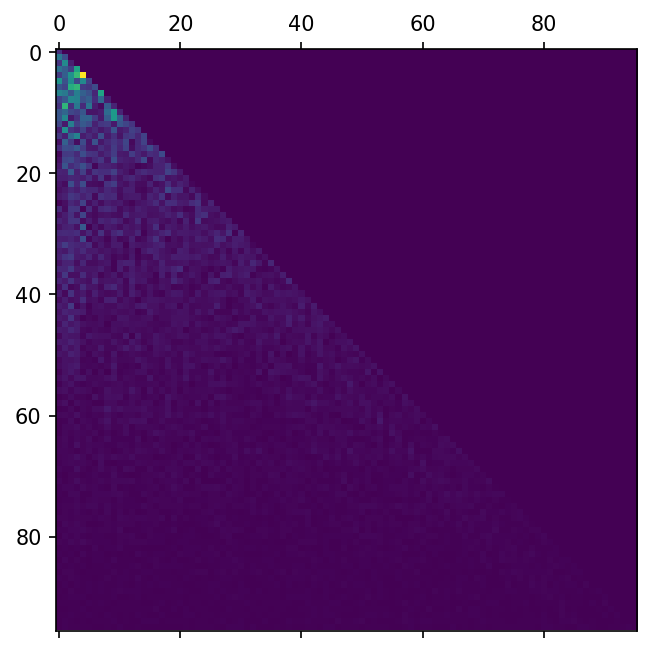

In [25]:
plt.matshow(np.abs(foo[1,:,:]))
plt.show()

In [26]:
# for debugging, keep almost all coeffs and verify we reproduce input
print foo.size
n_to_keep = 921000
temp = np.abs(foo).flatten()
thresh = np.partition(temp, -n_to_keep)[-n_to_keep]
print thresh
cut_foo = np.where(np.abs(foo) > thresh, foo, 0.0j)
print cut_foo.shape
del temp

921600
0.0
(100, 96, 96)


In [27]:
# try inverse transform
def inv_sh_transform(cplx_data):
    coeffs = np.array([np.real(cplx_data), np.imag(cplx_data)])
    return pyshtools.shtools.MakeGridDH(coeffs, sampling=2)

for i in range(n2):
    for j in range(i+1):
        cut_foo[:,i,j] = scipy.fftpack.ifft(cut_foo[:,i,j])
hoo = np.zeros((T, n, 2*n))
for t in range(T):
    hoo[t,:,:] = inv_sh_transform(cut_foo[t,:,:])

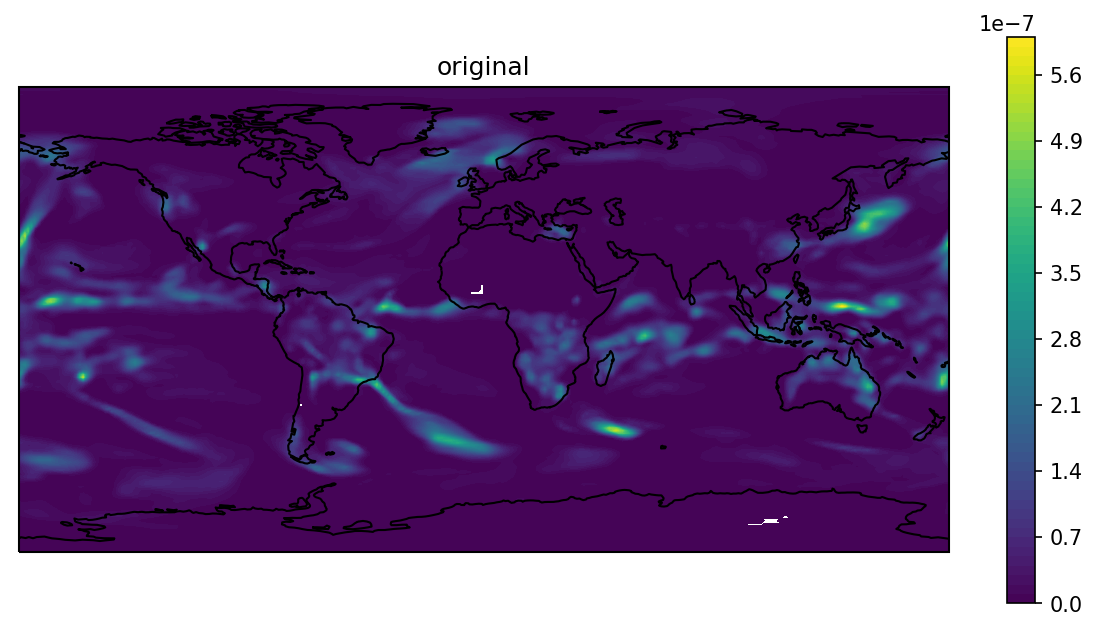

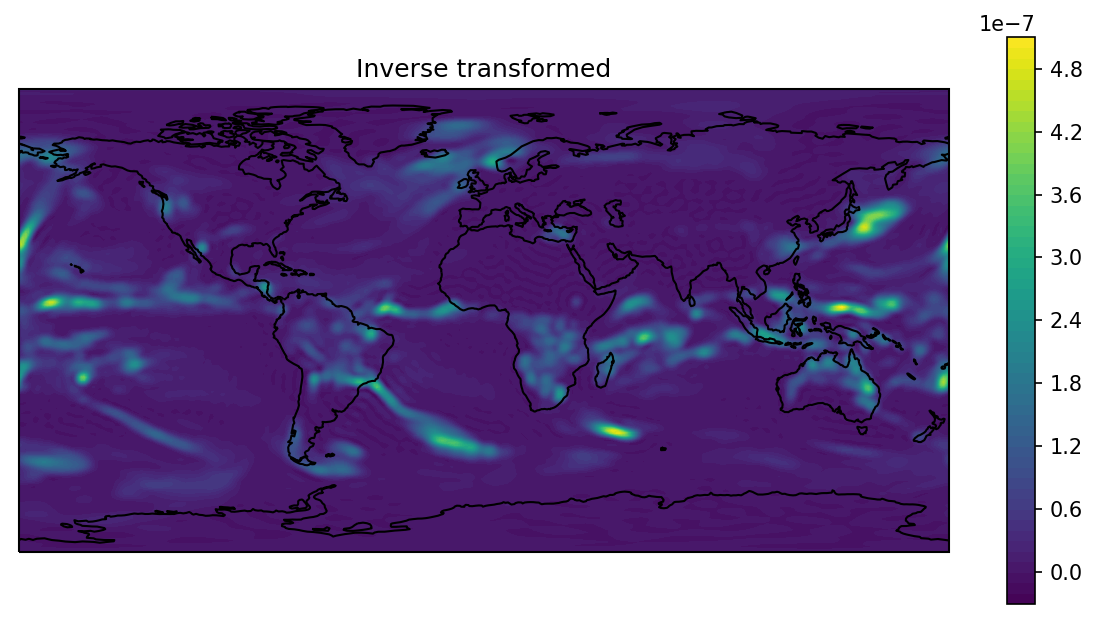

In [30]:
# verify we did that correctly
quick_plot(lats, lons, data2, title='original')
quick_plot(new_lats, new_lons, hoo[0,:,:], title='Inverse transformed')

Thresholding in space and time simultaneously is really a stretch: even keeping 10,000 coeffs doesn't reproduce a timeslice that well.

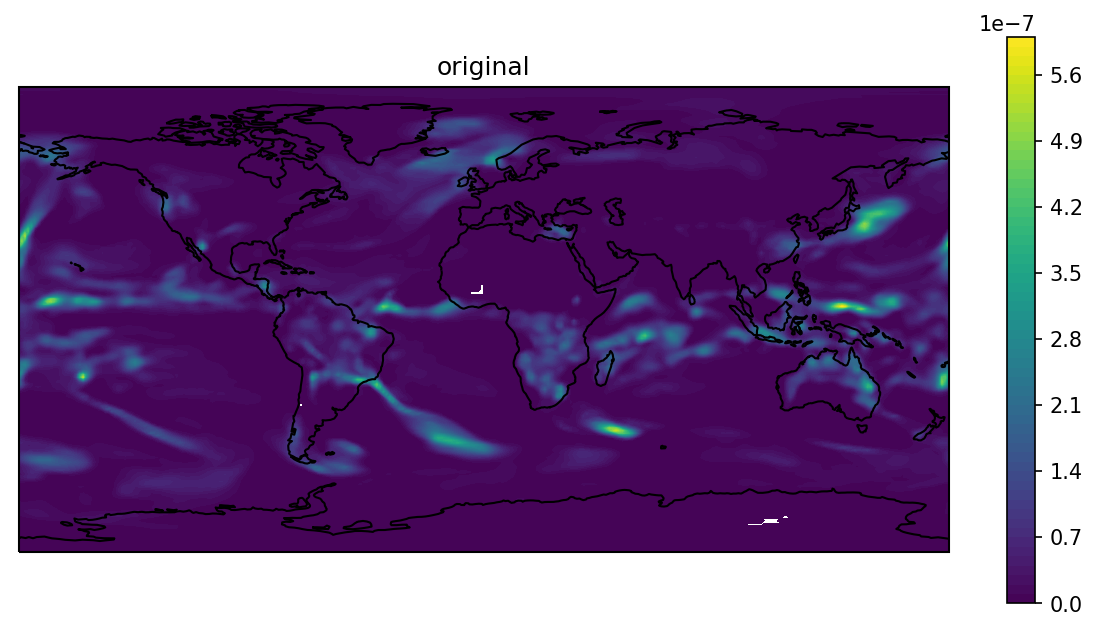

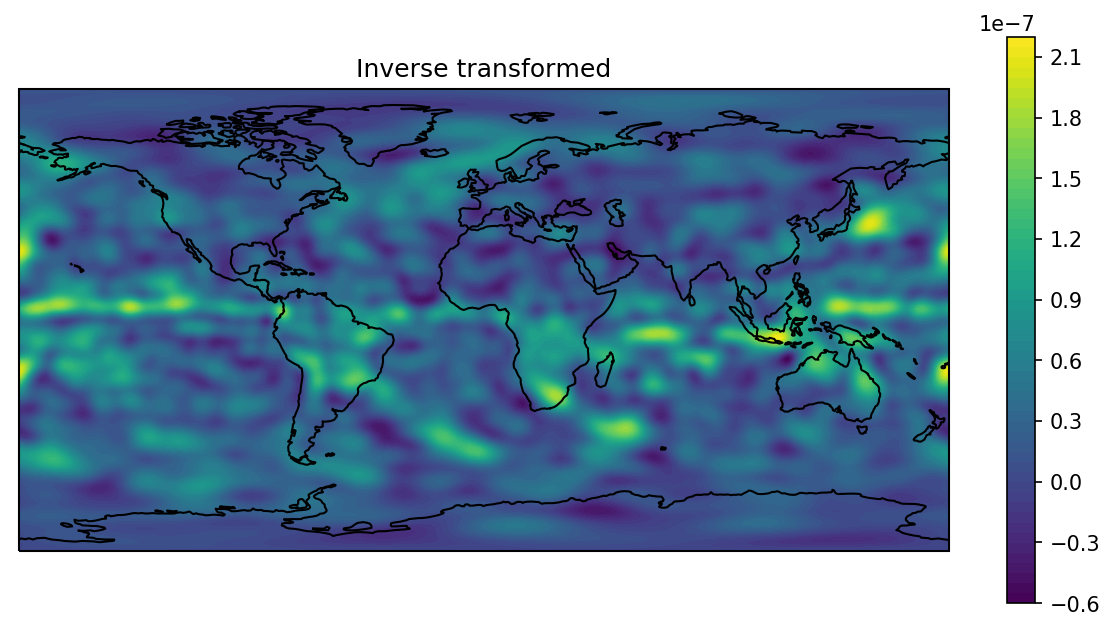

In [31]:
n_to_keep = 10000
temp = np.abs(foo).flatten()
thresh = np.partition(temp, -n_to_keep)[-n_to_keep]
del temp
cut_foo = np.where(np.abs(foo) > thresh, foo, 0.0j)

for i in range(n2):
    for j in range(i+1):
        cut_foo[:,i,j] = scipy.fftpack.ifft(cut_foo[:,i,j])
hoo = np.zeros((T, n, 2*n))
for t in range(T):
    hoo[t,:,:] = inv_sh_transform(cut_foo[t,:,:])
    
quick_plot(lats, lons, data2, title='original')
quick_plot(new_lats, new_lons, hoo[0,:,:], title='Inverse transformed')

In [255]:
# for output file: list nonzero components by indices in array and value
n_to_keep = 10000
temp = np.abs(foo).flatten()
thresh = np.partition(temp, -n_to_keep)[-n_to_keep]
del temp
cut_foo = np.argwhere(np.abs(foo) > thresh)

In [278]:
cut_vals = np.extract(np.abs(foo) > thresh, foo)
print cut_vals.shape
print np.expand_dims(cut_vals, axis=1).shape
hoo = np.transpose(np.array([np.real(cut_vals), np.imag(cut_vals)]))
print hoo.shape
print hoo[1,:]

(9999,)
(9999, 1)
(9999, 2)
[-3.25295364e-07  0.00000000e+00]


## Apply to different data

Package what we've done so far:

In [3]:
def dh2_grid(n):
    # generate lat/lon for grid used by SHtools (dims n x 2n).
    # see entry for 'griddh' at https://shtools.oca.eu/shtools/pymakegriddh.html
    new_lats = np.linspace(90, -90, n, endpoint=False)
    new_lats = np.flip(new_lats)
    new_lons = np.linspace(0, 360, 2*n, endpoint=False)
    new_pts = np.array(np.meshgrid(new_lats, new_lons))
    new_pts = np.transpose(new_pts, (2,1,0))
    return new_lats, new_lons, new_pts

def resample_slice_nc(t, dataset, var_name, lats, lons, new_pts):
    # resample data from 
    data_t = dataset.variables[var_name][t,:,:]
    fill_val = np.mean(data_t)
    data_t = data_t.filled(fill_val)
    # data_t = np.nan_to_num(data_t, nan=fill_val, 
    #                       posinf=fill_val, neg_inf = fill_val)
    assert(lats[0] < lats[-1]) # make sure axes are sorted
    assert(lons[0] < lons[-1])
    # pad interpolation data for periodicity in lon
    eps = 1.0e-6
    tmp_lats = lats
    tmp_lons = lons
    if lons[-1] < 360.0 - eps:
        data_t = np.concatenate((data_t, 
                                 np.expand_dims(data_t[:,0], 1)), 
                                axis = 1)
        tmp_lons = np.concatenate((tmp_lons, np.atleast_1d(360.0)))
    # as a safety check, interpn will throw ValueError if asked to 
    # extrapolate
    return interpn((tmp_lats, tmp_lons), data_t, new_pts, method='linear')

def sh_transform(data_t):
    # spherical harmonic transform of one time slice
    # package coefficients into single complex matrix
    coeffs = pyshtools.shtools.SHExpandDH(data_t, sampling=2)
    return np.vectorize(complex)(coeffs[0,:,:], coeffs[1,:,:])

def harmonic_transform(dataset, lat='lat', lon='lon', var_name='', 
                       n = -1, T = -1):
    # loop to take in a netCDF struct and return 3D array of
    # complex-valued transform coefficients. Takes ~1 min to execute.
    lats = dataset.variables[lat][:]
    lons = dataset.variables[lon][:]
    
    if n <= 0: # sets sampling resolution
        # take min so we don't need to extrapolate at south pole
        n = min(lats.size, lons.size//2)
    if T <= 0: # number of time slices
        T = dataset.variables[var_name].shape[0]
        
    _, _, new_pts = dh2_grid(n)
    fourier_coeffs = np.zeros((T, n//2, n//2), dtype='complex128')
    for t in range(T):
        data_t = resample_slice_nc(t, dataset, var_name, lats, lons, new_pts)
        fourier_coeffs[t,:,:] = sh_transform(data_t)
    # used SH transform on n x 2n grid, so at each t upper triangular
    # coeffs are 0 and don't need to be fft'ed
    for i in range(n//2):
        for j in range(i+1):
            fourier_coeffs[:,i,j] = np.fft.fft(fourier_coeffs[:,i,j])
    return fourier_coeffs

def cplx_threshold(cplx_data, n_to_keep=-1):
    # Take output of harmonic_transform and keep only the n_to_keep
    # largest components. Output are indices of these components and
    # real and imaginary part of their values.
    temp = np.abs(cplx_data).flatten()
    if n_to_keep < 0: n_to_keep = len(temp) # do not threshold
    # following finds n_to_keep'th largest entry of a vector without
    # fully sorting it
    thresh = np.partition(temp, -n_to_keep)[-n_to_keep]
    

    

In [4]:
def resample_slice(data_t, old_lat, old_lon, new_pts):
    # resample from DH2 grid to requested lat/lon (=new_pts)
    tmp_lats = np.concatenate((np.atleast_1d(-90.0), old_lat))  
    tmp_lons = np.concatenate((old_lon, np.atleast_1d(360.0)))
    s_pole_fill = np.mean(data_t[0,:])
    # ok to modify data_t input, since not used again
    # pad matrix for periodicity in lon
    data_t = np.concatenate((
        data_t, np.expand_dims(data_t[:,0], 1)), 
                            axis = 1)
    # fill in values at S pole by average
    data_t = np.concatenate((s_pole_fill * np.ones((1, data_t.shape[1])),
                             data_t), axis = 0) 
    # as a safety check, interpn will throw ValueError if asked to 
    # extrapolate
    return interpn((tmp_lats, tmp_lons), data_t, new_pts, method='linear')

def inv_sh_transform(cplx_data, n=-1):
    # inverse spherical harmonic transform
    # https://shtools.oca.eu/shtools/pymakegriddh.html
    if n <= 0:
        n = cplx_data.shape[0]
    lmax = n//2 - 1
    coeffs = np.stack((np.real(cplx_data), np.imag(cplx_data)), axis = 0)
    return pyshtools.shtools.MakeGridDH(coeffs, lmax=lmax, sampling=2)

def inv_harmonic_transform(inds, vals, dims, lats, lons):
    # inverts harmonic_transform from sparse representation
    (n, T) = dims
    n_to_keep = inds.shape[0]
    foo = np.zeros((T, n//2, n//2), dtype='complex128')
    cplx_vals = np.vectorize(complex)(vals[:,0], vals[:,1])
    for i in range(n//2):
        for j in range(i+1):
            mask = np.logical_and(inds[:,1] == i, inds[:,2] == j)
            if any(mask):
                temp = np.zeros((T), dtype='complex128')
                temp[inds[mask,0]] = cplx_vals[mask]
                foo[:,i,j] = np.fft.ifft(temp)
                
    new_n = max(lats.size, lons.size//2) + 2             
    dh2_lats, dh2_lons, _ = dh2_grid(new_n)
    out_pts = np.array(np.meshgrid(lats, lons))
    out_pts = np.transpose(out_pts, (2,1,0))
    hoo = np.zeros((T, len(lats), len(lons)))
    for t in range(T):
        data_t = inv_sh_transform(foo[t,:,:], n = new_n)
        hoo[t,:,:] = resample_slice(data_t, dh2_lats, dh2_lons, out_pts)
    return hoo

### Temperature

In [191]:
data_dir = '/local2/home/MDTF/inputdata/model/QBOi.EXP1.AMIP.001/day/'
file_path = os.path.join(data_dir, 'QBOi.EXP1.AMIP.001.T250.day.nc')
dataset = nc.Dataset(file_path)
print dataset.variables.keys()
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]
print dataset.variables['T250'].shape

[u'time', u'date', u'lat', u'lon', u'time_bnds', u'T250']
(2555, 192, 288)


In [234]:
# this takes ~3 min to run
var_name = 'T250'
n = dataset.variables[var_name].shape[1]
T = dataset.variables[var_name].shape[0]
foo = harmonic_transform(dataset, var_name=var_name)
inds, vals = cplx_threshold(foo, 100)
goo1 = inv_harmonic_transform(inds, vals, (n, T), lats, lons)
inds, vals = cplx_threshold(foo, 1000)
goo2 = inv_harmonic_transform(inds, vals, (n, T), lats, lons)
inds, vals = cplx_threshold(foo, 10000)
goo3 = inv_harmonic_transform(inds, vals, (n, T), lats, lons)

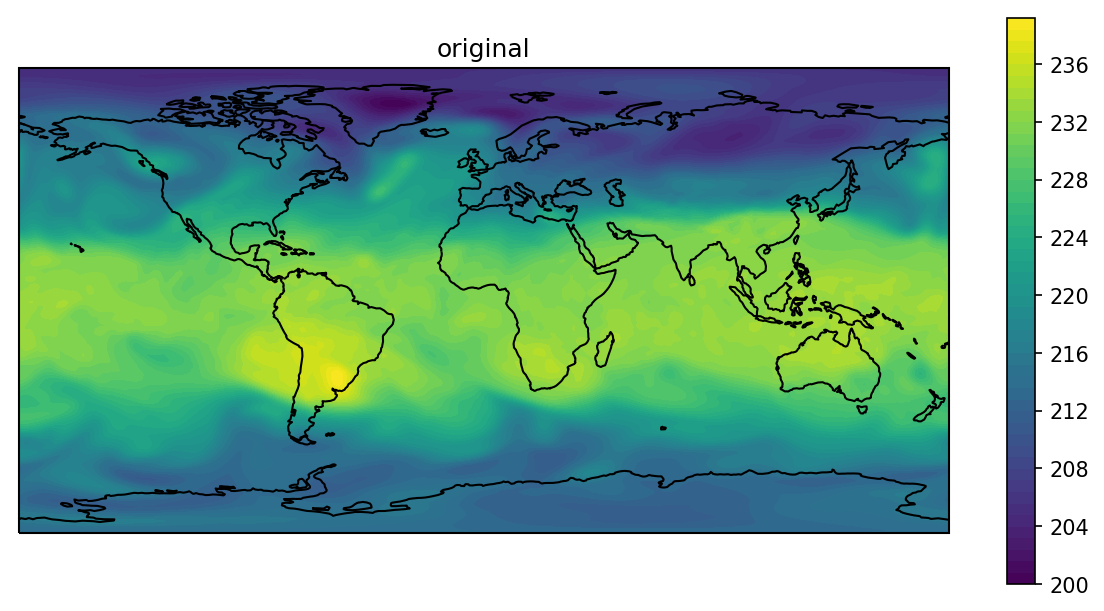

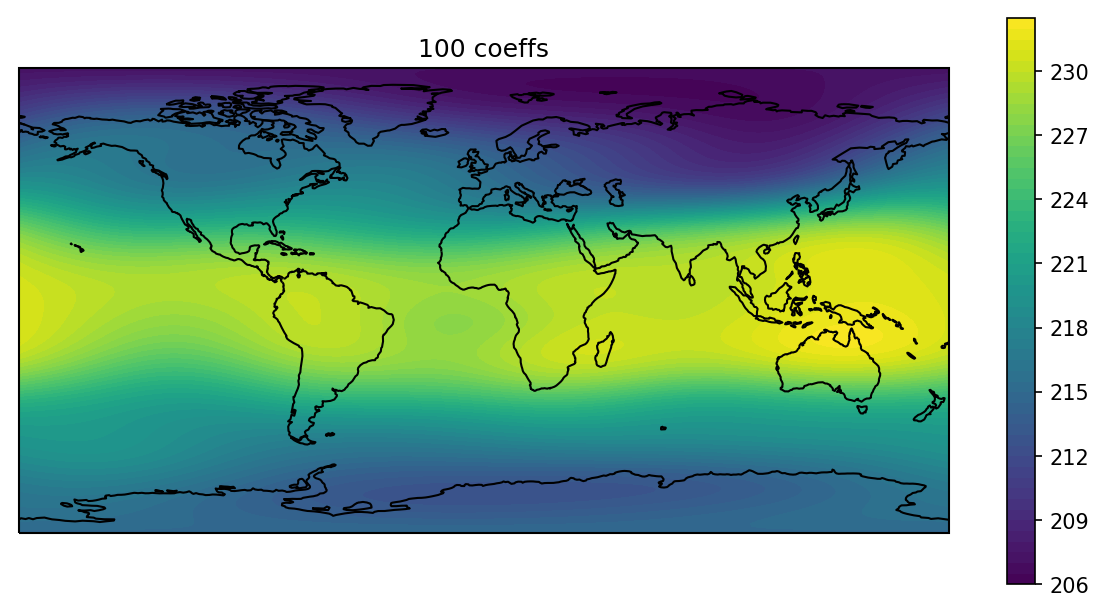

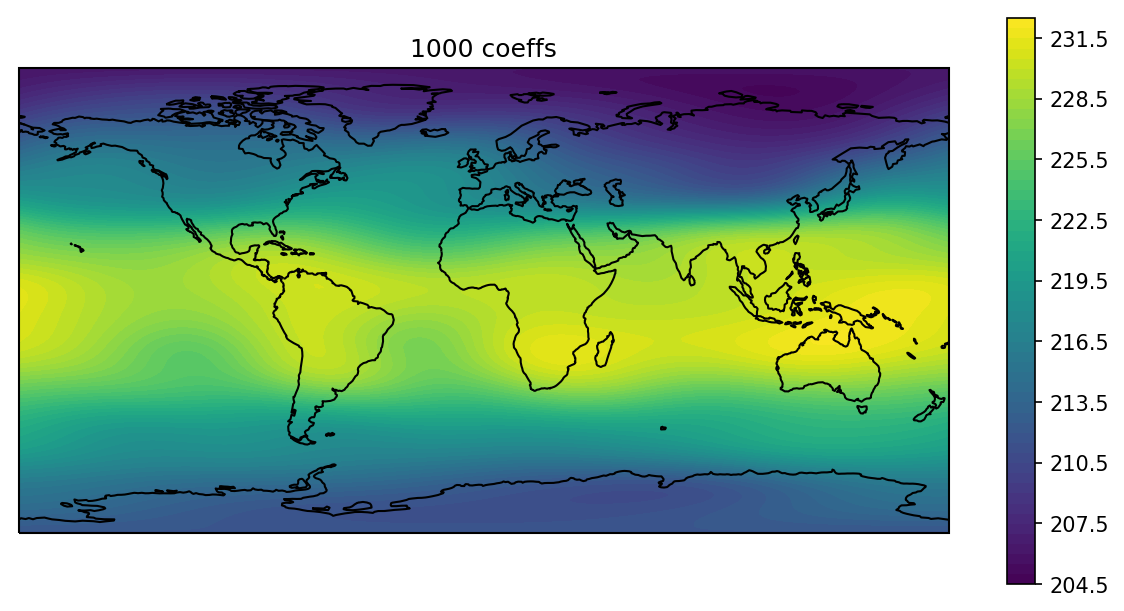

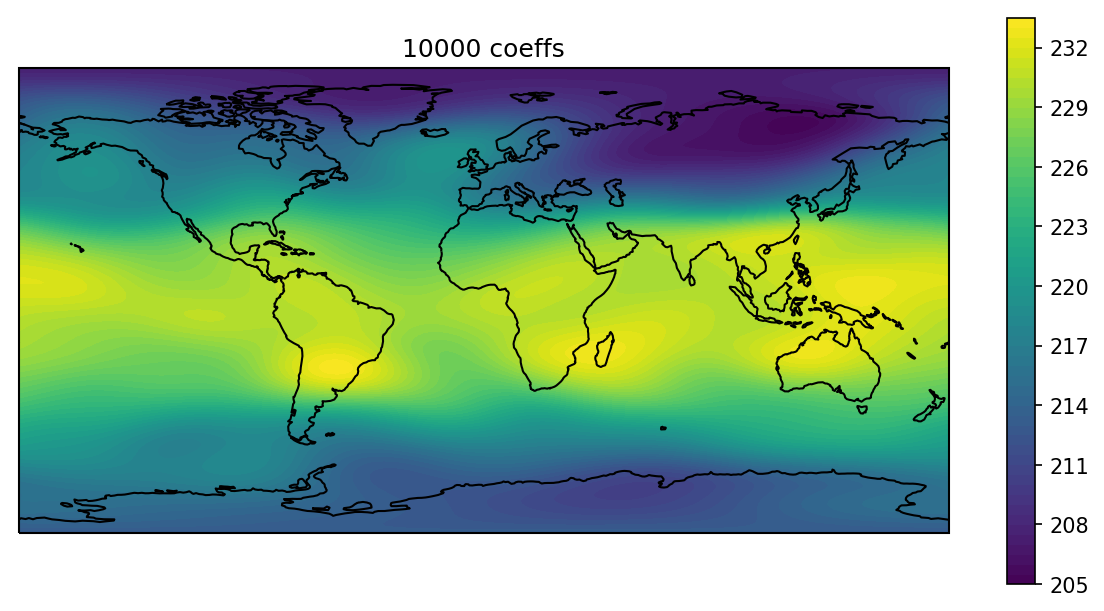

In [235]:
t = 0
quick_plot(lats, lons, dataset.variables[var_name][t,:,:],
          title='original')
quick_plot(lats, lons, goo1[t,:,:], title='100 coeffs')
quick_plot(lats, lons, goo2[t,:,:], title='1000 coeffs')
quick_plot(lats, lons, goo3[t,:,:], title='10000 coeffs')

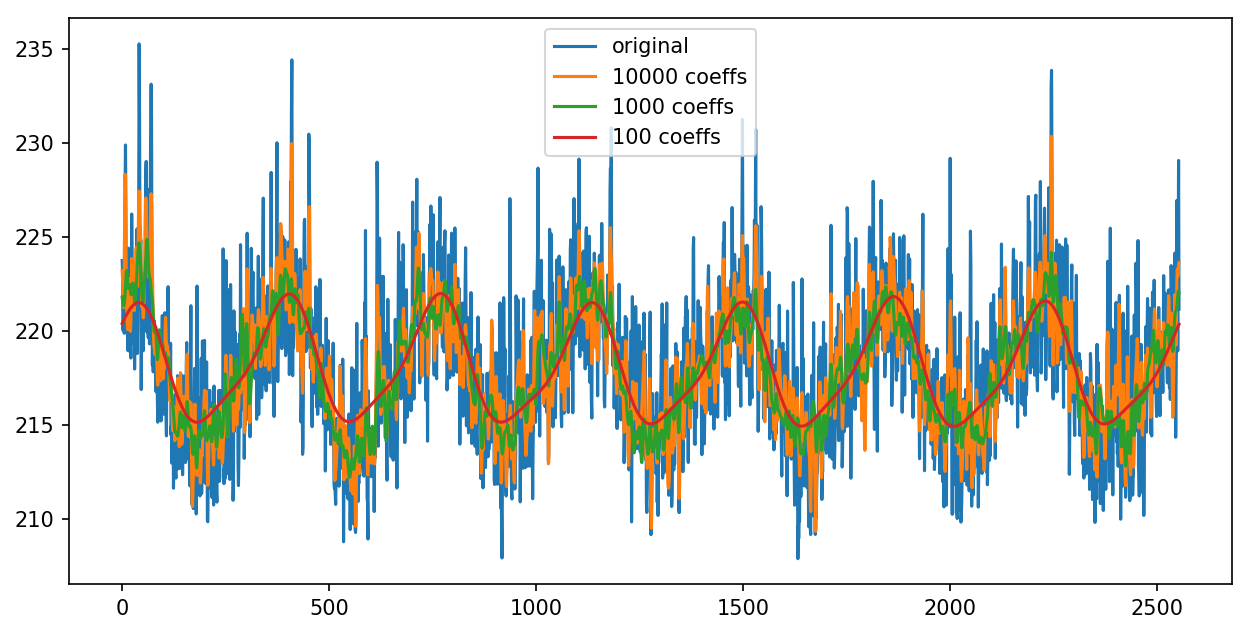

In [237]:
# timeseries for a location roughly on the eastern seaboard
lat_idx = 48
lon_idx = 72
plt.plot(dataset.variables[var_name][:,lat_idx, lon_idx])
plt.plot(goo3[:,lat_idx, lon_idx])
plt.plot(goo2[:,lat_idx, lon_idx])
plt.plot(goo1[:,lat_idx, lon_idx])
plt.legend(['original','10000 coeffs', '1000 coeffs', '100 coeffs'])
plt.show()

### Wind velocity

In [238]:
data_dir = '/local2/home/MDTF/inputdata/model/QBOi.EXP1.AMIP.001/day/'
file_path = os.path.join(data_dir, 'QBOi.EXP1.AMIP.001.V200.day.nc')
dataset = nc.Dataset(file_path)
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]
print dataset.variables['V200'].shape

(2580, 192, 288)


This is from the same model -- why is the time axis different from the temp timeseries??

In [239]:
# this takes ~3 min to run
var_name = 'V200'
n = dataset.variables[var_name].shape[1]
T = dataset.variables[var_name].shape[0]
foo = harmonic_transform(dataset, var_name=var_name)
inds, vals = cplx_threshold(foo, 100)
goo1 = inv_harmonic_transform(inds, vals, (n, T), lats, lons)
inds, vals = cplx_threshold(foo, 1000)
goo2 = inv_harmonic_transform(inds, vals, (n, T), lats, lons)
inds, vals = cplx_threshold(foo, 10000)
goo3 = inv_harmonic_transform(inds, vals, (n, T), lats, lons)

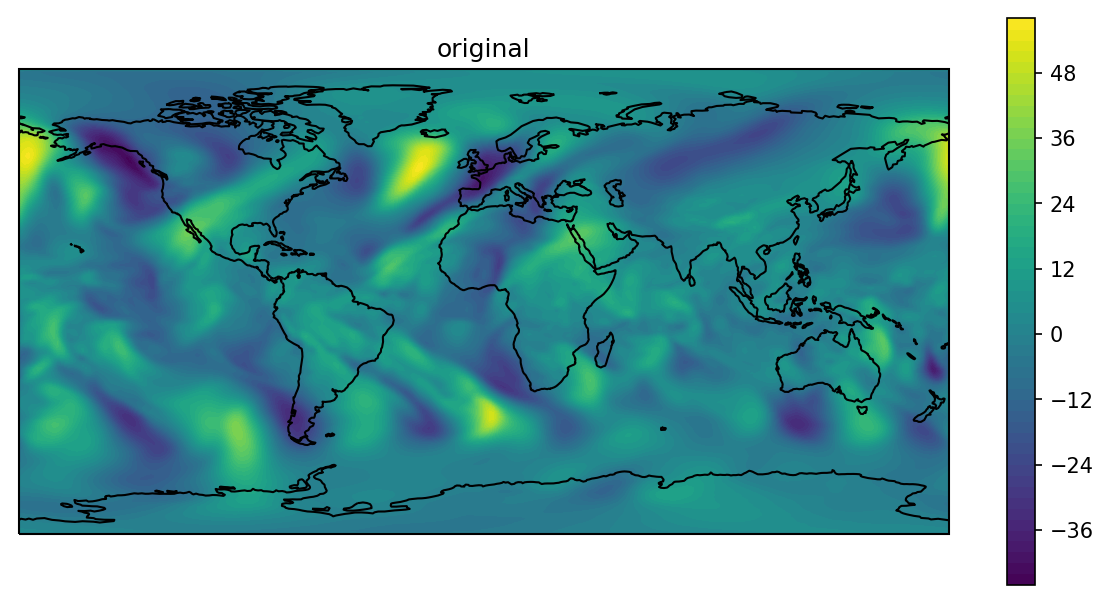

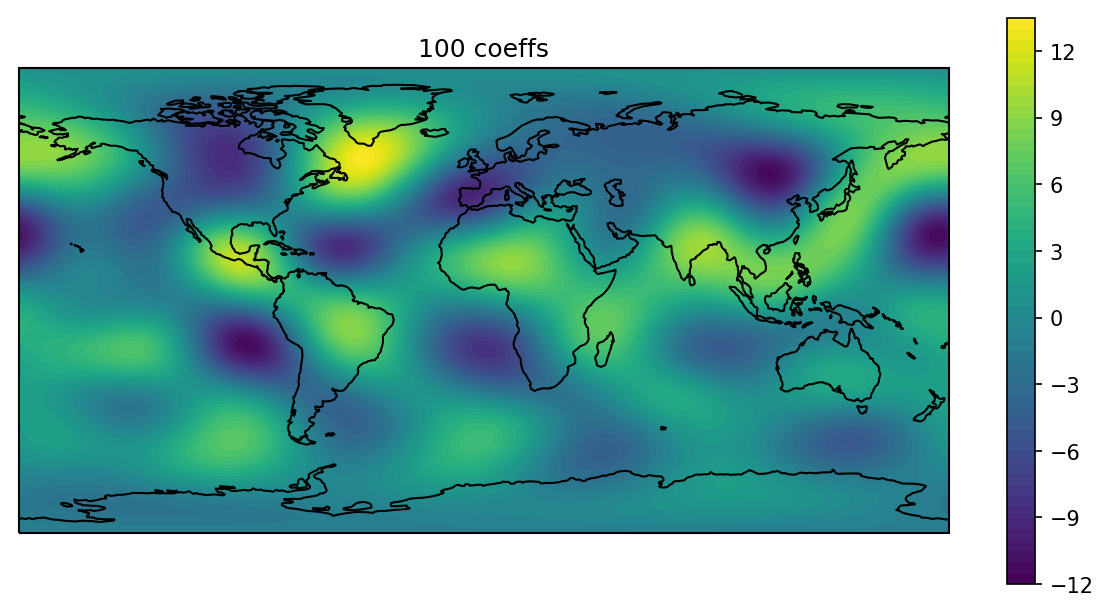

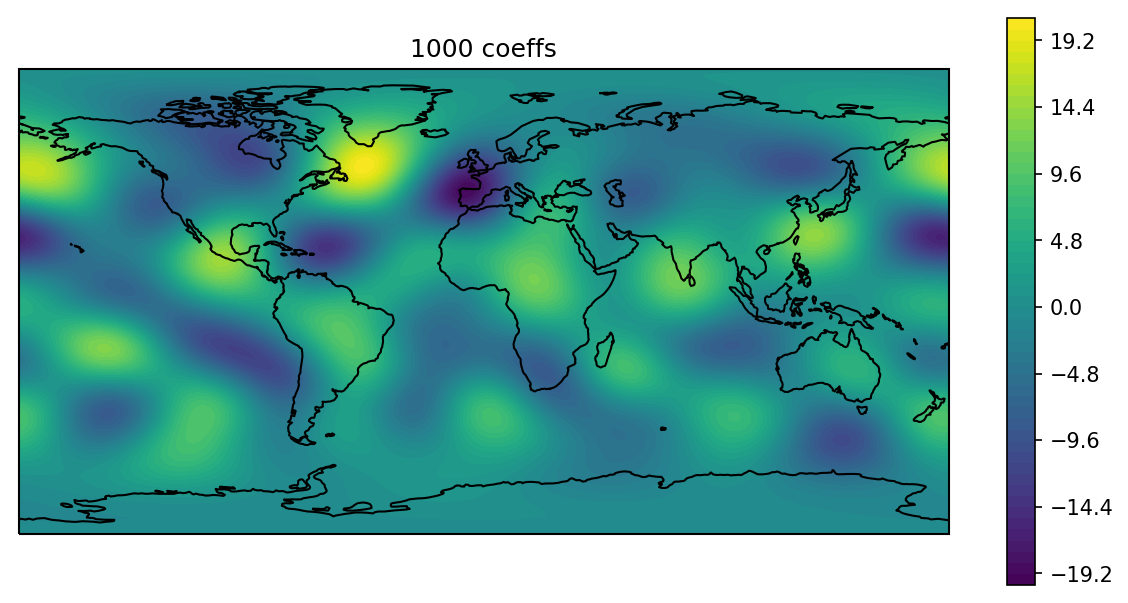

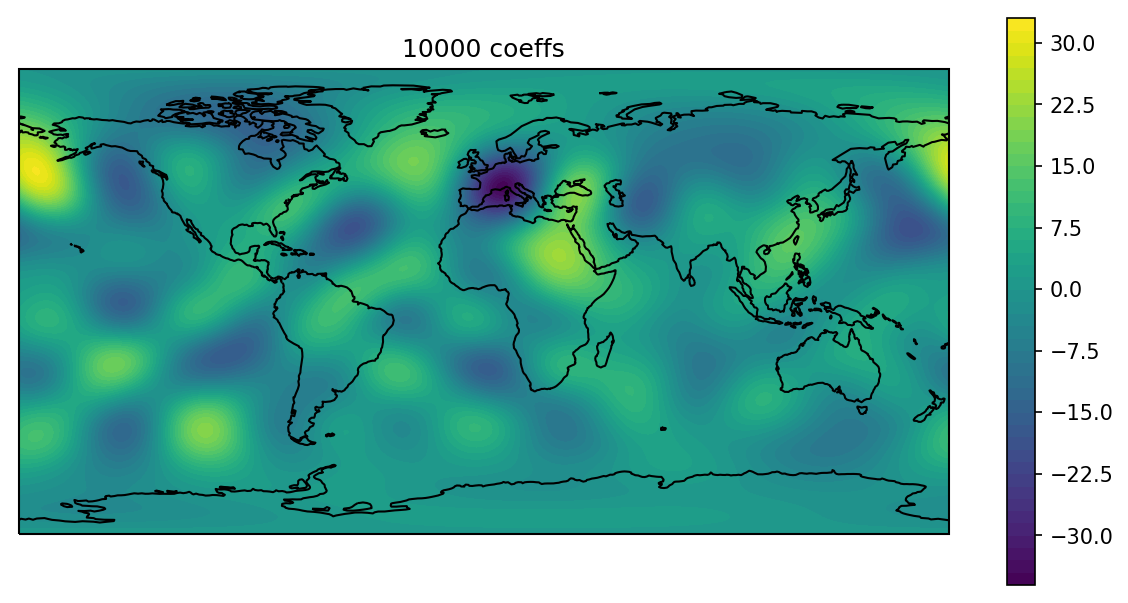

In [241]:
t = 0
quick_plot(lats, lons, dataset.variables[var_name][t,:,:],
          title='original')
quick_plot(lats, lons, goo1[t,:,:], title='100 coeffs')
quick_plot(lats, lons, goo2[t,:,:], title='1000 coeffs')
quick_plot(lats, lons, goo3[t,:,:], title='10000 coeffs')

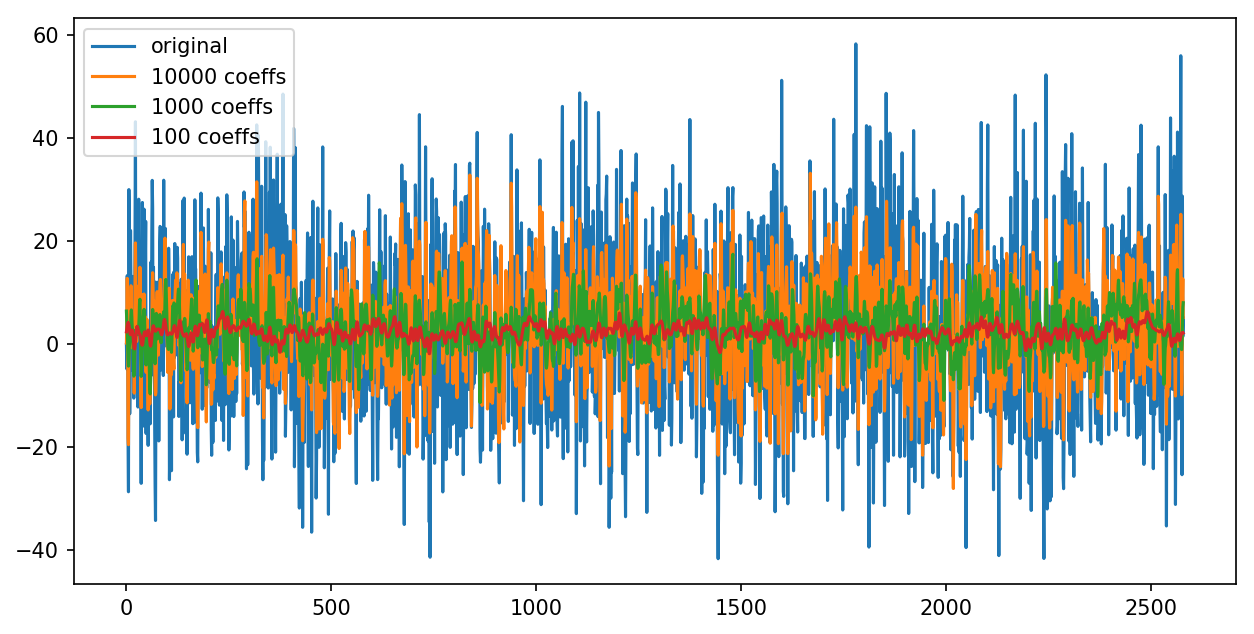

In [242]:
# timeseries for a location roughly on the eastern seaboard
lat_idx = 48
lon_idx = 72
plt.plot(dataset.variables[var_name][:,lat_idx, lon_idx])
plt.plot(goo3[:,lat_idx, lon_idx])
plt.plot(goo2[:,lat_idx, lon_idx])
plt.plot(goo1[:,lat_idx, lon_idx])
plt.legend(['original','10000 coeffs', '1000 coeffs', '100 coeffs'])
plt.show()

### Precip

In [243]:
data_dir = '/local2/home/MDTF/inputdata/model/QBOi.EXP1.AMIP.001/day/'
file_path = os.path.join(data_dir, 'QBOi.EXP1.AMIP.001.PRECT.day.nc')
dataset = nc.Dataset(file_path)
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]
print dataset.variables['PRECT'].shape

(2555, 192, 288)


In [244]:
# this takes ~3 min to run
var_name = 'PRECT'
n = dataset.variables[var_name].shape[1]
T = dataset.variables[var_name].shape[0]
foo = harmonic_transform(dataset, var_name=var_name)
inds, vals = cplx_threshold(foo, 100)
goo1 = inv_harmonic_transform(inds, vals, (n, T), lats, lons)
inds, vals = cplx_threshold(foo, 1000)
goo2 = inv_harmonic_transform(inds, vals, (n, T), lats, lons)
inds, vals = cplx_threshold(foo, 10000)
goo3 = inv_harmonic_transform(inds, vals, (n, T), lats, lons)

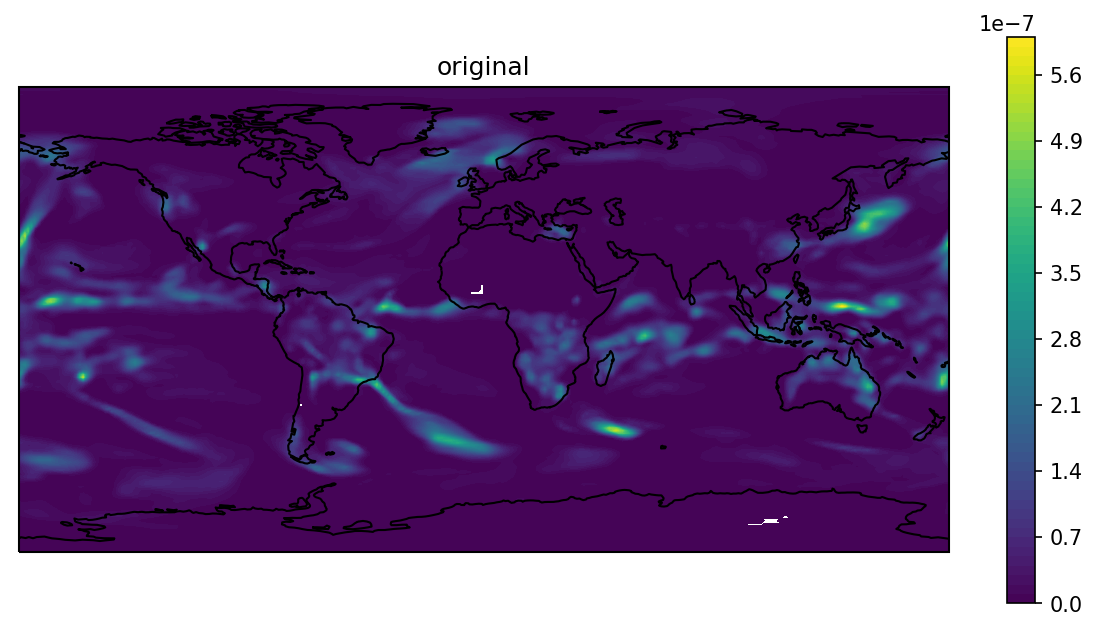

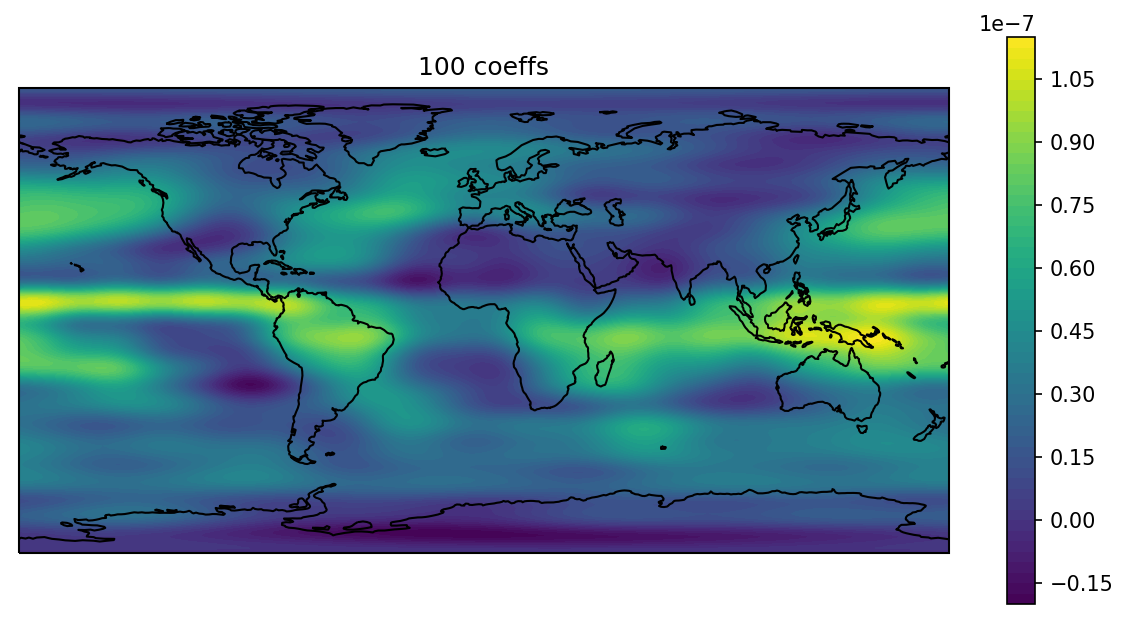

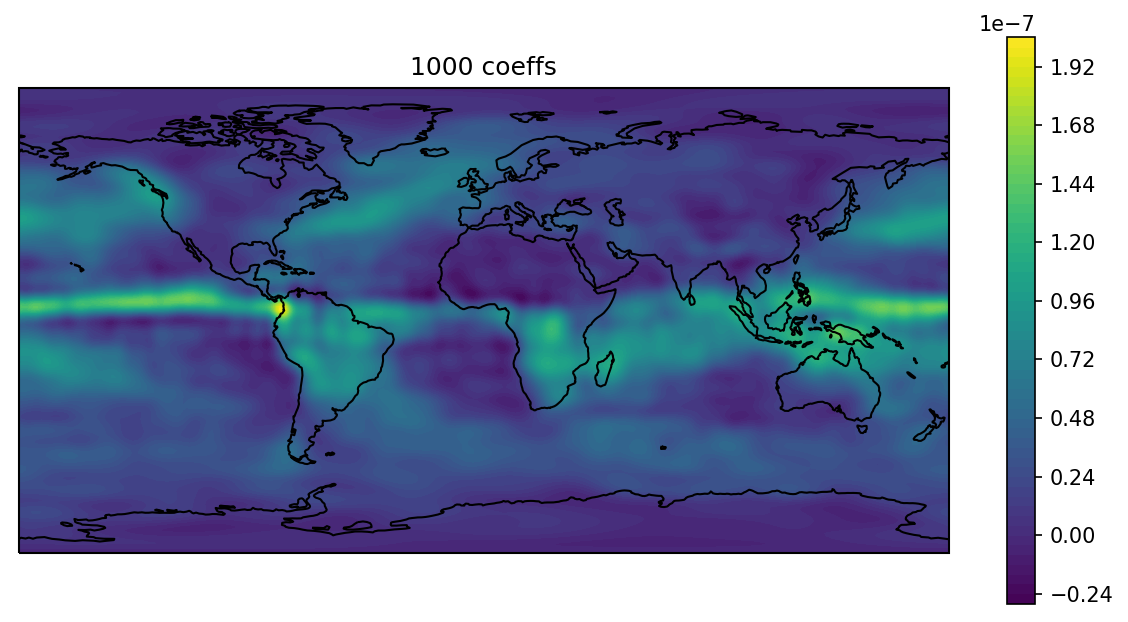

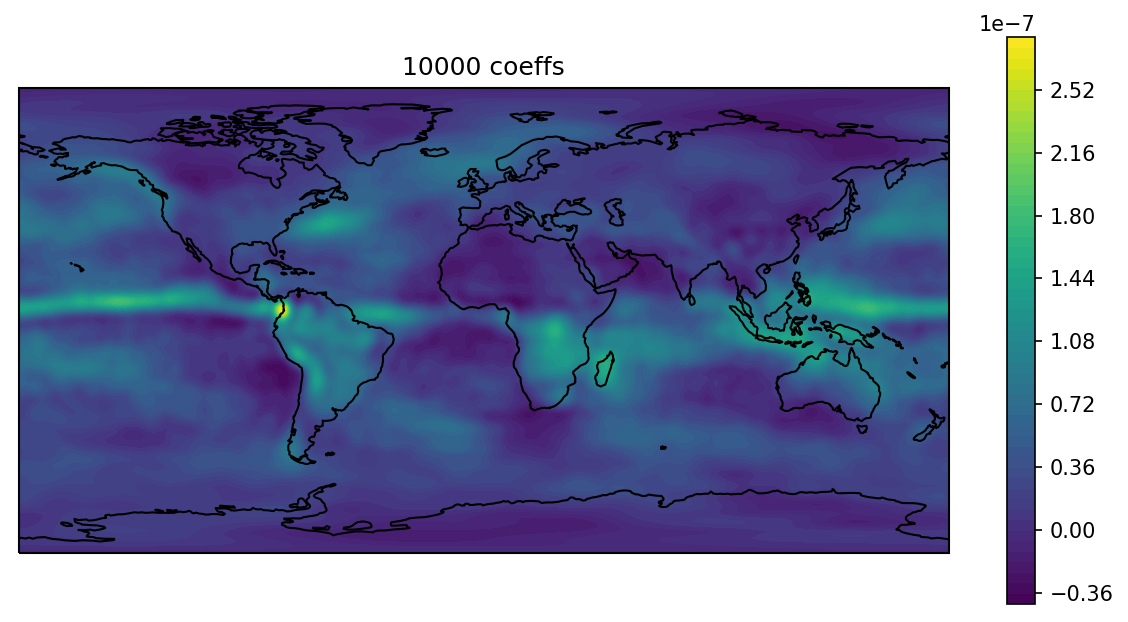

In [245]:
t = 0
quick_plot(lats, lons, dataset.variables[var_name][t,:,:],
          title='original')
quick_plot(lats, lons, goo1[t,:,:], title='100 coeffs')
quick_plot(lats, lons, goo2[t,:,:], title='1000 coeffs')
quick_plot(lats, lons, goo3[t,:,:], title='10000 coeffs')

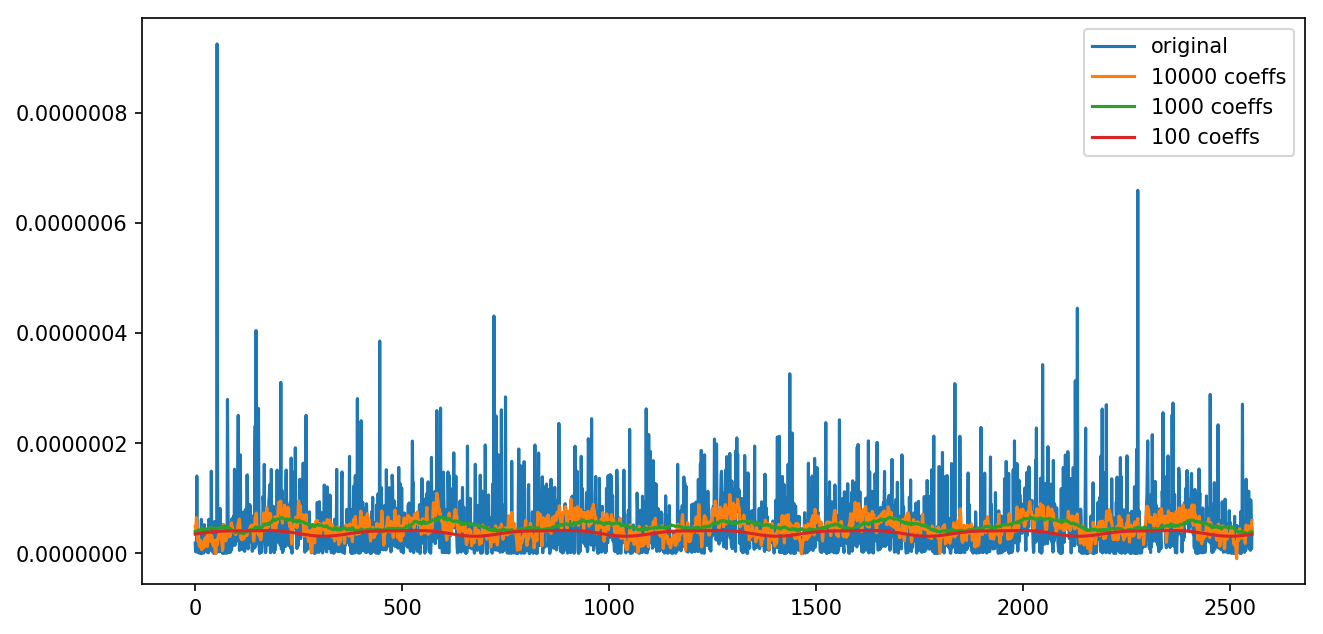

In [246]:
# timeseries for a location roughly on the eastern seaboard
lat_idx = 48
lon_idx = 72
plt.plot(dataset.variables[var_name][:,lat_idx, lon_idx])
plt.plot(goo3[:,lat_idx, lon_idx])
plt.plot(goo2[:,lat_idx, lon_idx])
plt.plot(goo1[:,lat_idx, lon_idx])
plt.legend(['original','10000 coeffs', '1000 coeffs', '100 coeffs'])
plt.show()

### Outgoing LW flux

In [247]:
data_dir = '/local2/home/MDTF/inputdata/model/QBOi.EXP1.AMIP.001/day/'
file_path = os.path.join(data_dir, 'QBOi.EXP1.AMIP.001.FLUT.day.nc')
dataset = nc.Dataset(file_path)
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]
print dataset.variables['FLUT'].shape

(2555, 192, 288)


In [248]:
# this takes ~3 min to run
var_name = 'FLUT'
n = dataset.variables[var_name].shape[1]
T = dataset.variables[var_name].shape[0]
foo = harmonic_transform(dataset, var_name=var_name)
inds, vals = cplx_threshold(foo, 100)
goo1 = inv_harmonic_transform(inds, vals, (n, T), lats, lons)
inds, vals = cplx_threshold(foo, 1000)
goo2 = inv_harmonic_transform(inds, vals, (n, T), lats, lons)
inds, vals = cplx_threshold(foo, 10000)
goo3 = inv_harmonic_transform(inds, vals, (n, T), lats, lons)

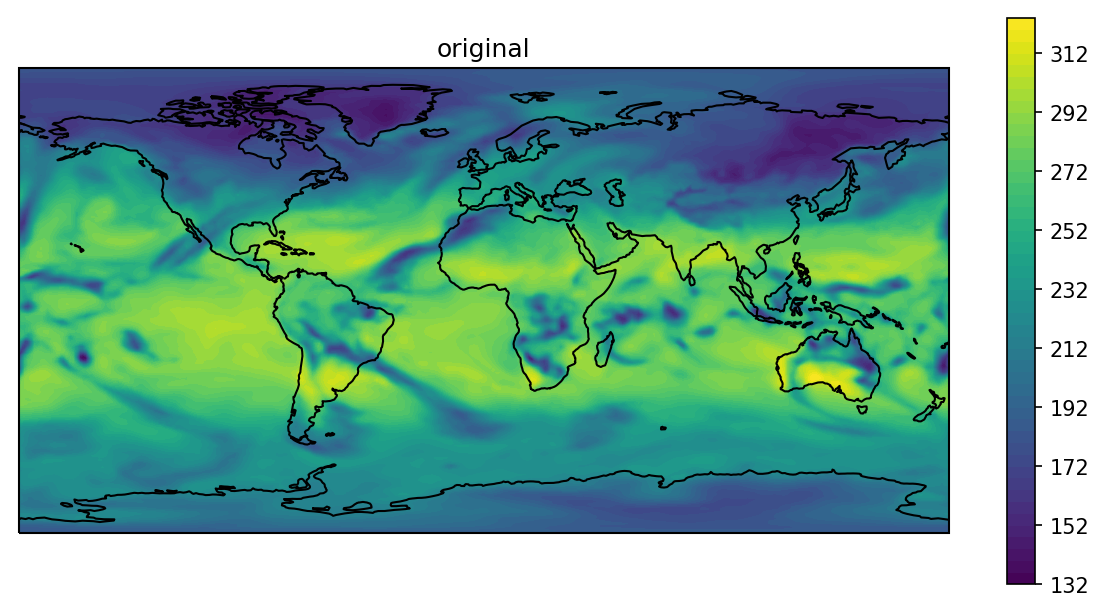

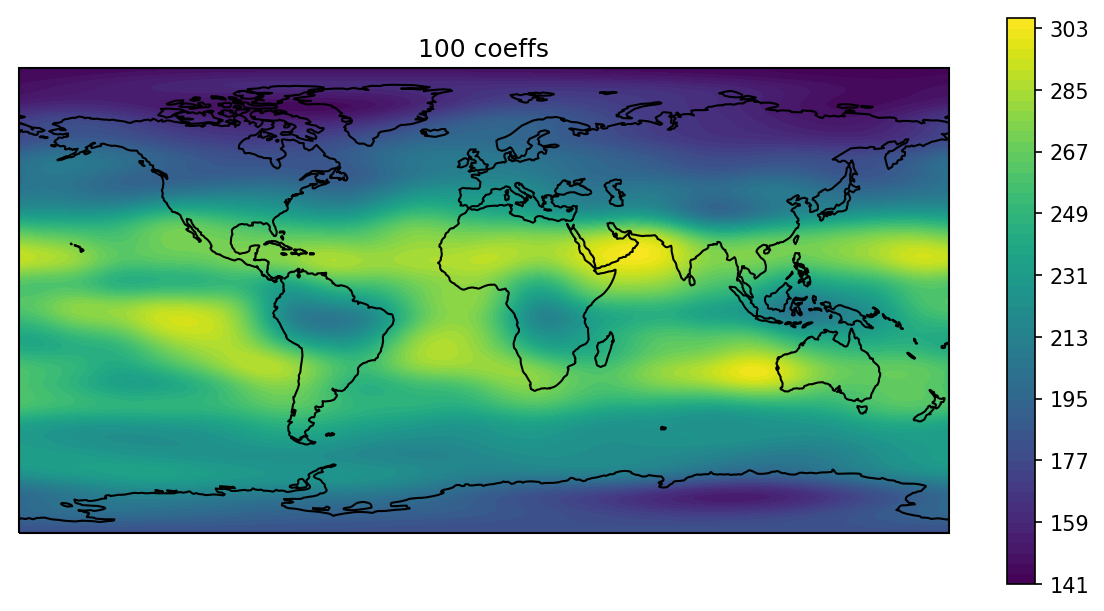

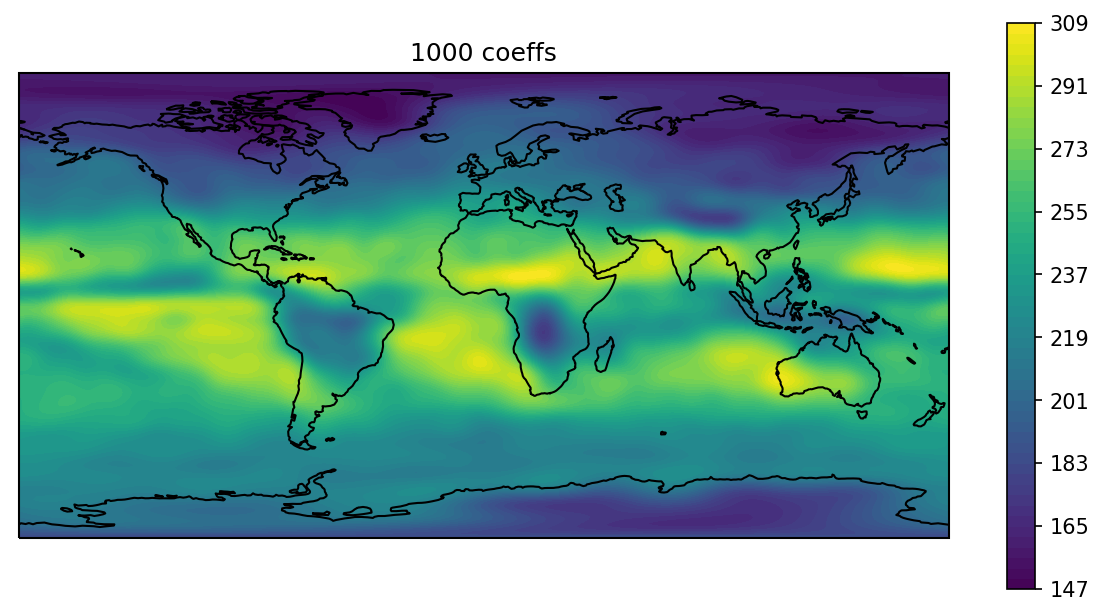

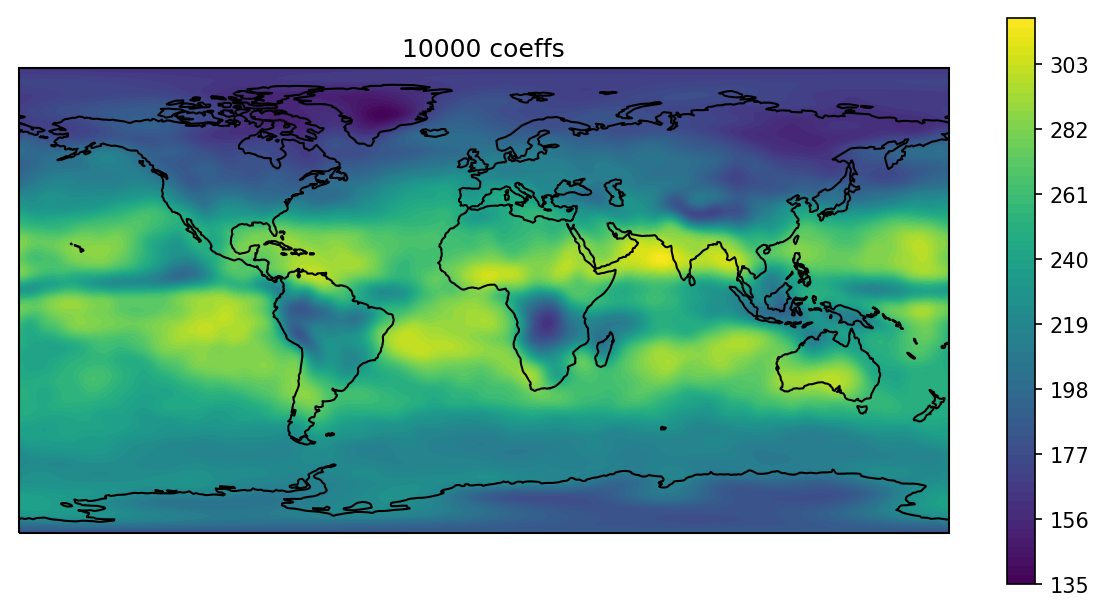

In [249]:
t = 0
quick_plot(lats, lons, dataset.variables[var_name][t,:,:],
          title='original')
quick_plot(lats, lons, goo1[t,:,:], title='100 coeffs')
quick_plot(lats, lons, goo2[t,:,:], title='1000 coeffs')
quick_plot(lats, lons, goo3[t,:,:], title='10000 coeffs')

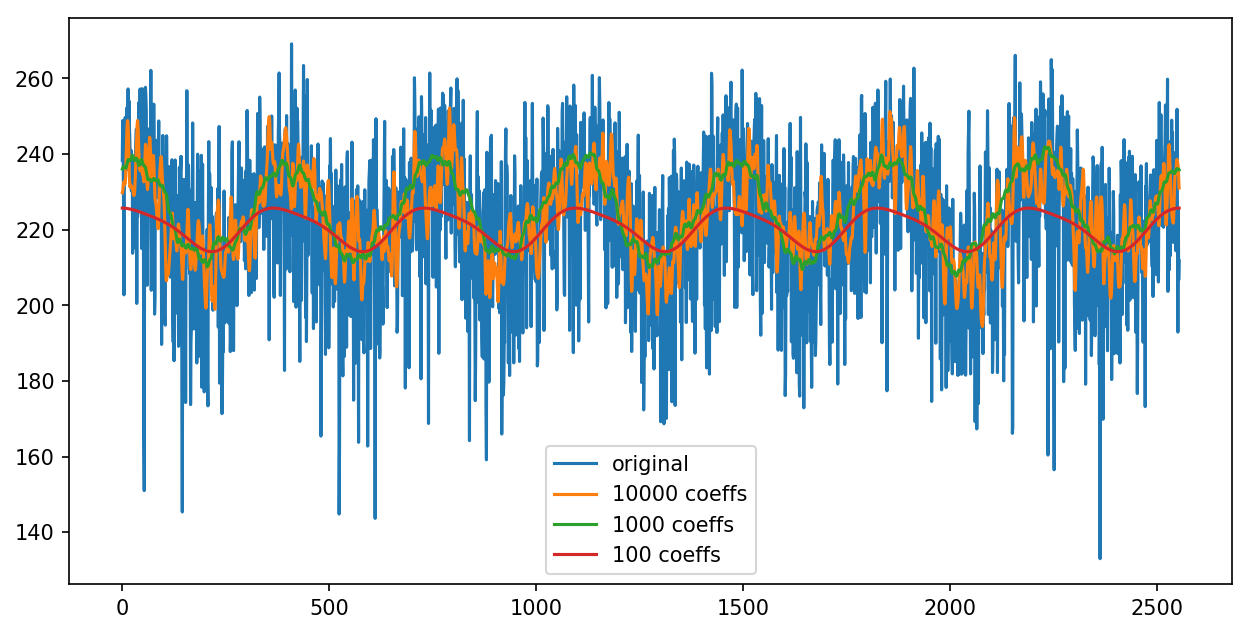

In [250]:
# timeseries for a location roughly on the eastern seaboard
lat_idx = 48
lon_idx = 72
plt.plot(dataset.variables[var_name][:,lat_idx, lon_idx])
plt.plot(goo3[:,lat_idx, lon_idx])
plt.plot(goo2[:,lat_idx, lon_idx])
plt.plot(goo1[:,lat_idx, lon_idx])
plt.legend(['original','10000 coeffs', '1000 coeffs', '100 coeffs'])
plt.show()

## reconstruct without dependency on SHTools

In [ ]:
# TBD

## Output netCDFs

In [5]:
data_dir = '/local2/home/MDTF/inputdata/model/QBOi.EXP1.AMIP.001/day/'
out_dir = '/local2/home/MDTF/inputdata/model/sh_test2/day/'
var_names = ['PRECT','T250','U200','V200','U250','U850',
             'V850','OMEGA500','Z250','FLUT']
for var in var_names:
    print var
    data_path = os.path.join(data_dir, 'QBOi.EXP1.AMIP.001.'+var+'.day.nc')
    out_path = os.path.join(out_dir, 'sh_test2.'+var+'.day.nc')
    d_in = nc.Dataset(data_path, 'r')
    d_out = nc.Dataset(out_path, 'w')

    # copy contents of d_in to d_out
    d_out.setncatts(d_in.__dict__)
    # copy dimensions
    for name, dimension in d_in.dimensions.items():
        d_out.createDimension(
            name, (len(dimension) if not dimension.isunlimited() else None))
    # copy all file data except for the excluded
    for name, variable in d_in.variables.items():
        x = d_out.createVariable(name, variable.datatype, variable.dimensions)
        # copy variable attributes all at once via dictionary
        d_out[name].setncatts(d_in[name].__dict__)
        d_out[name][:] = d_in[name][:]

    lats = d_in.variables['lat'][:]
    lons = d_in.variables['lon'][:]
    n = d_in.variables[var].shape[1]
    T = d_in.variables[var].shape[0]

    print 'Doing transform'
    foo = harmonic_transform(d_in, var_name=var)
    inds, vals = cplx_threshold(foo, 10000)
    d_out.variables[var][:] = inv_harmonic_transform(inds, vals, (n, T), lats, lons)
    print 'done'
    d_in.close()
    d_out.close()

PRECT
Doing transform
done
T250
Doing transform
done
U200
Doing transform
done
V200
Doing transform
done
U250
Doing transform
done
U850
Doing transform
done
V850
Doing transform
done
OMEGA500
Doing transform
done
Z250
Doing transform
done
FLUT
Doing transform
done
